In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
detA = pd.read_csv("../data/DetectorA.csv", header=None, names=["event_id", "class_score", "energy"])
detB = pd.read_csv("../data/DetectorB.csv", header=None, names=["event_id", "class_score", "energy"])
detC = pd.read_csv("../data/DetectorC.csv", header=None, names=["event_id", "class_score", "energy"])
detTarget = pd.read_csv("../data/DetectorTarget.csv", header=None, names=["event_id", "class_score", "energy"])

In [5]:
detA.head()

,event_id,class_score,energy
0,734628.0,0.440,2123.514
1,229218.0,0.179,1017.985
2,428880.0,0.028,1862.961
3,1990.0,0.080,1619.836
4,55401.0,0.065,2611.720


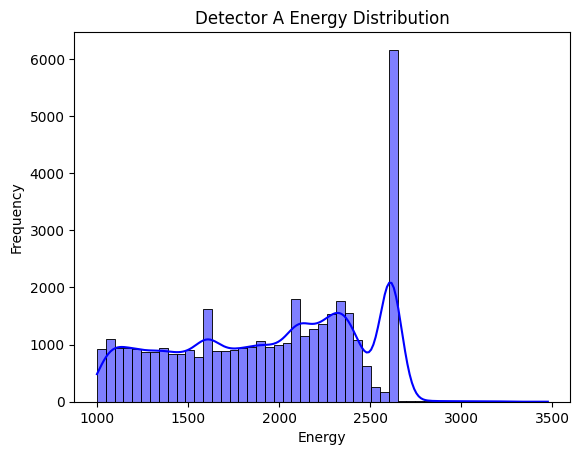

In [ ]:
sns.histplot(detA["energy"], kde=True, color="blue")
plt.title("Detector A Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

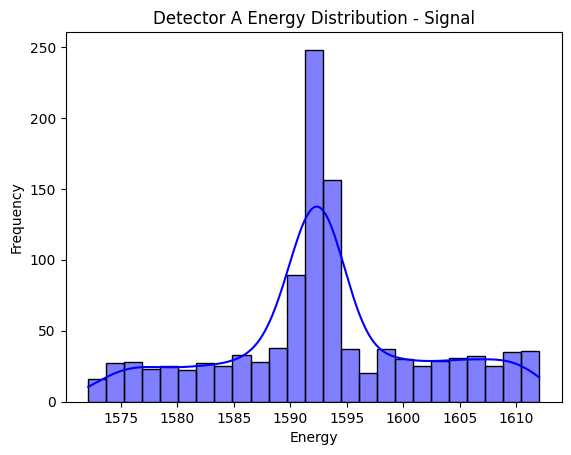

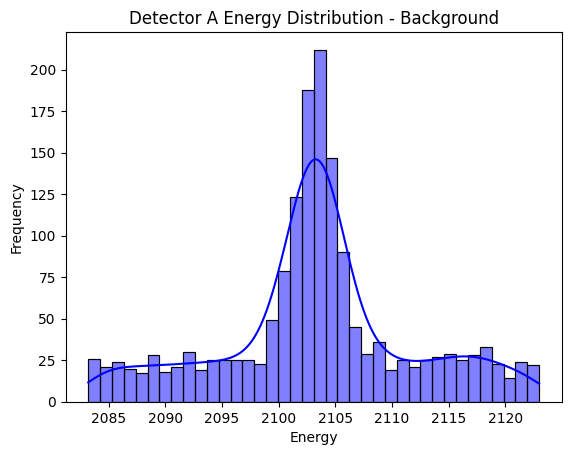

In [22]:
delta = 20
signal = 1592
background = 2103
A_signal = detA[(detA["energy"] >= signal - delta) & (detA["energy"] <= signal + delta)]
A_background = detA[(detA["energy"] >= background - delta) & (detA["energy"] <= background + delta)]

sns.histplot(A_signal["energy"], kde=True, color="blue")
plt.title("Detector A Energy Distribution - Signal")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

sns.histplot(A_background["energy"], kde=True, color="blue")
plt.title("Detector A Energy Distribution - Background")
plt.xlabel("Energy")
plt.ylabel("Frequency")
plt.show()

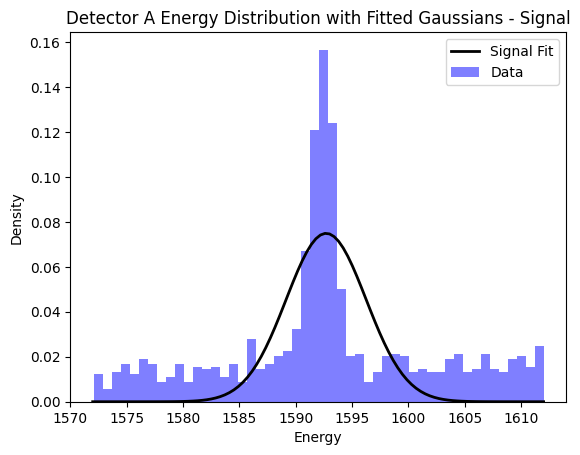

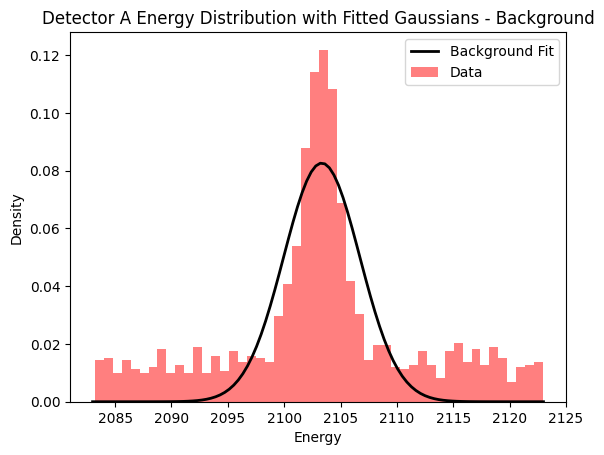

In [28]:
# fit gaussian to signal and background peaks
from scipy.stats import norm
mu_signal, std_signal = norm.fit(A_signal["energy"])
mu_background, std_background = norm.fit(A_background["energy"])

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


from scipy.optimize import curve_fit

p0 = [1., signal, 1.]

hist, bin_edges = np.histogram(A_signal["energy"], density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# plot fitted gaussian against true dists
xmin, xmax = signal - delta, signal + delta
x = np.linspace(xmin, xmax, 100)
p_signal = gauss(x, *coeff)
plt.plot(x, p_signal, 'k', linewidth=2, label='Signal Fit')
plt.hist(A_signal["energy"], bins=50, density=True, alpha=0.5, color='blue', label='Data')
plt.title("Detector A Energy Distribution with Fitted Gaussians - Signal")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.show()

p0 = [1., background, 1.]

hist, bin_edges = np.histogram(A_background["energy"], density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
xmin, xmax = background - delta, background + delta
x = np.linspace(xmin, xmax, 100)
p_background = gauss(x, *coeff)
plt.plot(x, p_background, 'k', linewidth=2, label='Background Fit')
plt.hist(A_background["energy"], bins=50, density=True, alpha=0.5, color='red', label='Data')
plt.title("Detector A Energy Distribution with Fitted Gaussians - Background")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.show()

Kind of suggests Nate's initial guess of using +/- 6 is pretty good. I'll try with 8 for now to include more data.

Detector A - Best Threshold: 0.10101010101010102, TPR: 0.7593880389429764, FPR: 0.2619893428063943


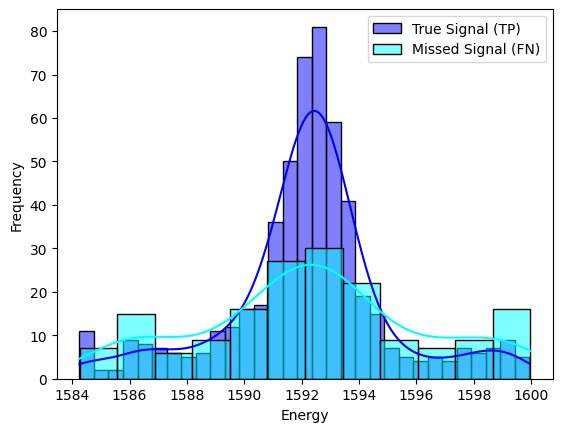

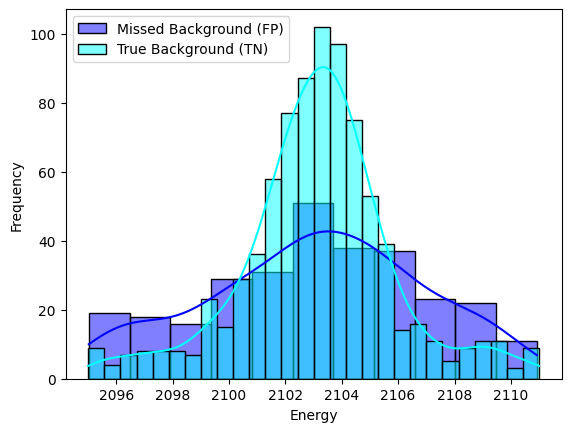

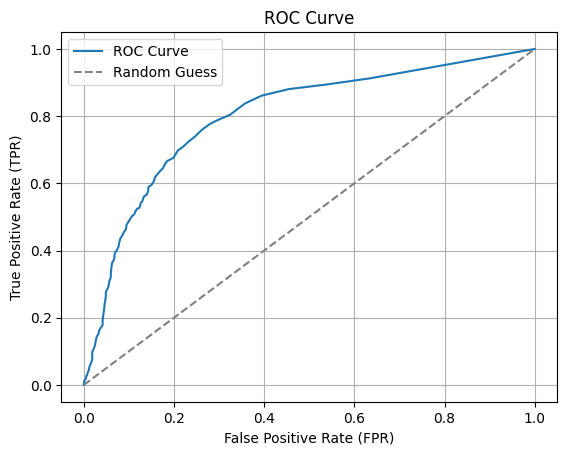

In [34]:
# determine your cutting threshold on detector A using both of its 1592 peak 
# (signal) and 2103 peak (background)
# perform baseline subtraction as needed

def threshold_calc(data, delta, name):
    tprs = []
    fprs = []
    signal = 1592
    background = 2103
    signal = data[(data["energy"] >= signal - delta) & (data["energy"] <= signal + delta)]
    background = data[(data["energy"] >= background - delta) & (data["energy"] <= background + delta)]

    best_tpr = 0
    best_fpr = 1
    best_threshold = 0
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        tp = np.sum((signal['class_score'] >= threshold))
        fp = np.sum((background['class_score'] >= threshold))
        fn = np.sum((signal['class_score'] < threshold))
        tn = np.sum((background['class_score'] < threshold))
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tprs.append(tpr)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fprs.append(fpr)
        
        if tpr - fpr > best_tpr - best_fpr:
            best_tpr = tpr
            best_fpr = fpr
            best_threshold = threshold
    
    print(f"Detector {name} - Best Threshold: {best_threshold}, TPR: {best_tpr}, FPR: {best_fpr}")
    sns.histplot(signal[signal['class_score'] >= best_threshold]['energy'], color='blue', label='True Signal (TP)', kde=True)
    sns.histplot(signal[signal['class_score'] < best_threshold]['energy'], color='cyan', label='Missed Signal (FN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    sns.histplot(background[background['class_score'] >= best_threshold]['energy'], color='blue', label='Missed Background (FP)', kde=True)
    sns.histplot(background[background['class_score'] < best_threshold]['energy'], color='cyan', label='True Background (TN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    plt.plot(fprs, tprs, linestyle='-', label="ROC Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return best_threshold   

THRESHOLD = threshold_calc(detA, delta, 'A')
# threshold_calc(detB, delta, 'B')

# FINAL CODE

In [3]:
delta = 20
signal = 1592
background = 2103
A_signal = detA[(detA["energy"] >= signal - delta) & (detA["energy"] <= signal + delta)]
A_background = detA[(detA["energy"] >= background - delta) & (detA["energy"] <= background + delta)]

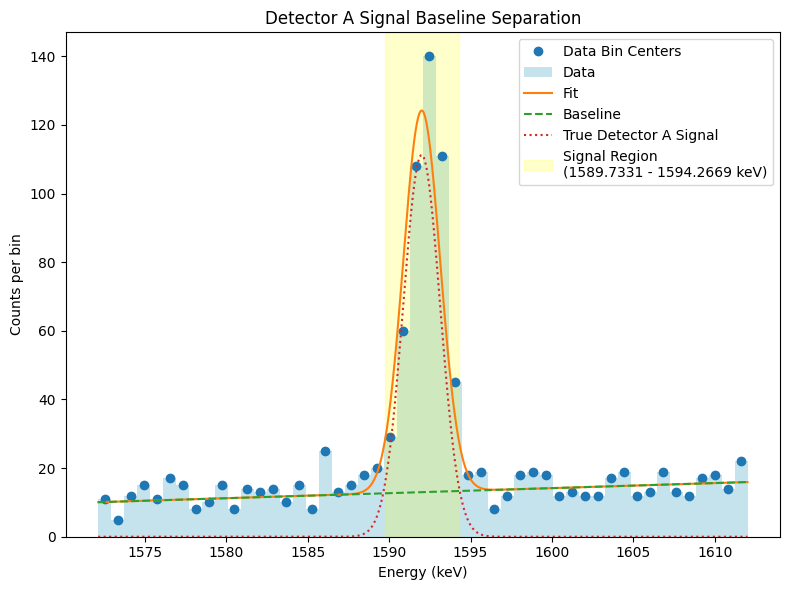

Fit results:
A = 139.56382222227467
mu = 1592.0
sigma = 1.1334474236882466
a = 16.28939367647242
b = 0.18488645067547654


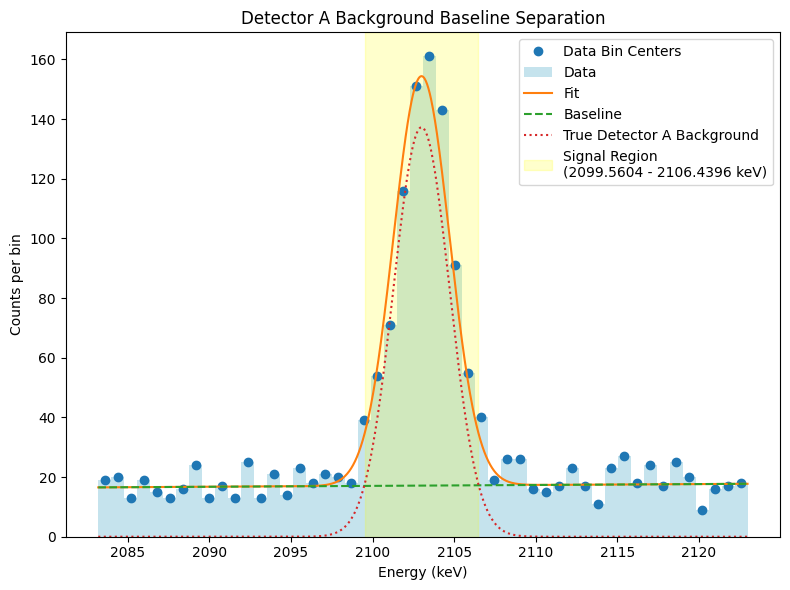

Fit results:
A = 172.4185014185809
mu = 2103.0
sigma = 1.7197990866203536
a = 21.524766585480588
b = 0.03785043436778327


In [7]:
from iminuit import Minuit

def fit_signal_background(data, n_bins, mu, name):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    bin_width = (bin_edges[-1] - bin_edges[0]) / n_bins
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    def fit_function(x, A, mu, sigma, a, b):
        signal = A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        background = a + b * (x - mu)
        return signal + background

    # Define the chi-square function to minimize.
    def chi2(A, mu, sigma, a, b):
        expected = fit_function(bin_centers, A, mu, sigma, a, b) * bin_width
        mask = counts > 0
        return np.sum(((counts[mask] - expected[mask])**2) / counts[mask])
    
    # Implement the Minuit fitting below
    m = Minuit(chi2, A=np.max(counts) * bin_width, mu=mu, sigma=1, a=np.mean(counts) / bin_width, b=0)
    m.limits["A"] = (0, None)
    m.limits["sigma"] = (0, None)
    m.limits["a"] = (0, None)
    m.fixed["mu"] = True
    m.migrad()
    A_fit, mu_fit, sigma_fit, a_fit, b_fit = m.values["A", "mu", "sigma", "a", "b"]

    # Calculate Signal and Background counts in the signal region
    signal_region_min = mu_fit - 2 * sigma_fit
    signal_region_max = mu_fit + 2 * sigma_fit
    # signal_region = (bin_centers >= signal_region_min) & (bin_centers <= signal_region_max)

    # all_signals = np.sum(counts[signal_region])
    # backgrounds = np.sum(fit_function(bin_centers[signal_region], 0, mu_fit, sigma_fit, a_fit, b_fit) * bin_width)
    # signals = all_signals - backgrounds

    m_fine = np.linspace(min(data), max(data), 1000)
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, counts, 'o', label='Data Bin Centers')
    plt.hist(data, bins=n_bins, alpha=0.7, 
             label='Data', color='lightblue', density=False)
    plt.plot(m_fine, fit_function(m_fine, A_fit, mu_fit, sigma_fit, a_fit, b_fit) * bin_width, '-', label='Fit')
    plt.plot(m_fine, fit_function(m_fine, 0, mu_fit, sigma_fit, a_fit, b_fit) * bin_width, '--', label='Baseline')
    plt.plot(m_fine, fit_function(m_fine, A_fit, mu_fit, sigma_fit, 0, 0) * bin_width, ':', label=f'True {name}')
    plt.axvspan(signal_region_min, signal_region_max, alpha=0.2, color='yellow', 
                label=f'Signal Region\n({signal_region_min:.4f} - {signal_region_max:.4f} keV)')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts per bin')
    plt.legend(loc="upper right")
    plt.title(f"{name} Baseline Separation")
    plt.tight_layout()
    plt.show()

    print(f"Fit results:")
    print(f"A = {A_fit}")
    print(f"mu = {mu_fit}")
    print(f"sigma = {sigma_fit}")
    print(f"a = {a_fit}")
    print(f"b = {b_fit}")

    return signal_region_min, signal_region_max

true_signal_min, true_signal_max = fit_signal_background(A_signal["energy"].values, n_bins=50, mu=signal, name="Detector A Signal")
true_background_min, true_background_max = fit_signal_background(A_background["energy"].values, n_bins=50, mu=background, name="Detector A Background")

In [32]:
true_A_signal_energy = A_signal[(A_signal["energy"] >= true_signal_min) & (A_signal["energy"] <= true_signal_max)]
true_A_background_energy = A_background[(A_background["energy"] >= true_background_min) & (A_background["energy"] <= true_background_max)]
B_signal_energy = detB[(detB["energy"] >= true_signal_min) & (detB["energy"] <= true_signal_max)]
B_background_energy = detB[(detB["energy"] >= true_background_min) & (detB["energy"] <= true_background_max)]
C_signal_energy = detC[(detC["energy"] >= true_signal_min) & (detC["energy"] <= true_signal_max)]
C_background_energy = detC[(detC["energy"] >= true_background_min) & (detC["energy"] <= true_background_max)]
target_signal_energy = detTarget[(detTarget["energy"] >= true_signal_min) & (detTarget["energy"] <= true_signal_max)]
target_background_energy = detTarget[(detTarget["energy"] >= true_background_min) & (detTarget["energy"] <= true_background_max)]

Detector A - Best Threshold: 0.10101010101010102, TPR: 0.8115942028985508, FPR: 0.20512820512820512


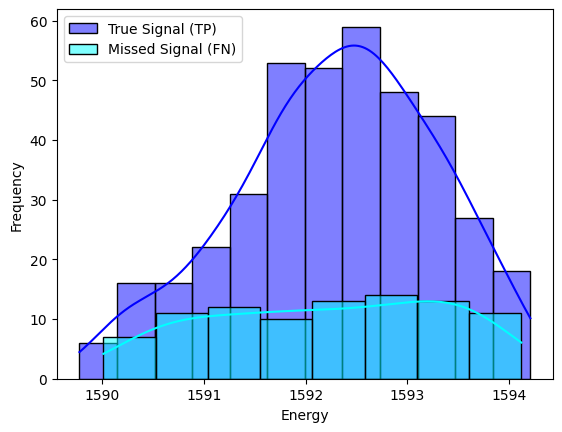

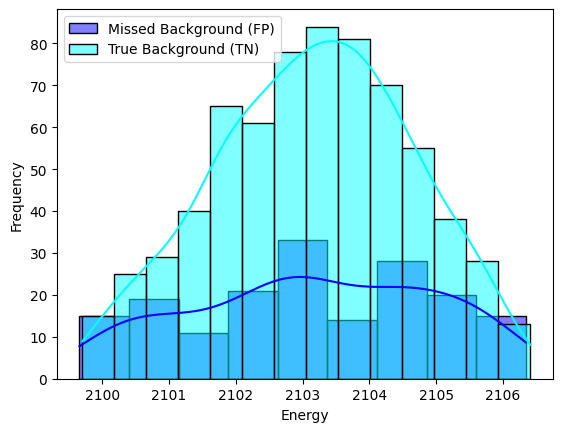

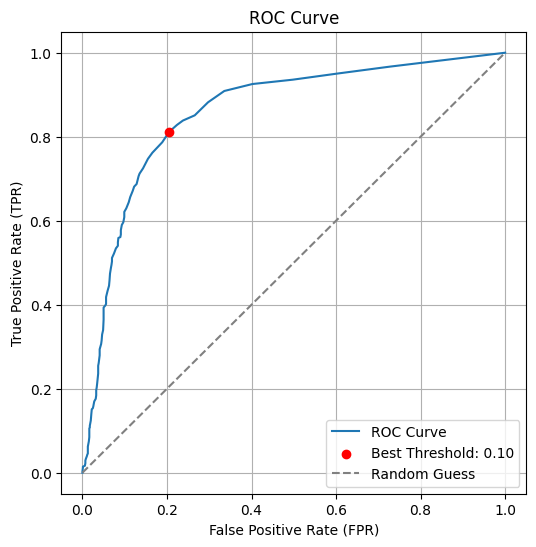

In [31]:
# determine your cutting threshold on detector A using both of its 1592 peak 
# (signal) and 2103 peak (background)
# perform baseline subtraction as needed

def threshold_calc(signal, background, name):
    tprs = []
    fprs = []
    
    best_tpr = 0
    best_fpr = 1
    best_threshold = 0
    thresholds = np.linspace(0, 1, 100)
    for threshold in thresholds:
        tp = np.sum((signal['class_score'] >= threshold))
        fp = np.sum((background['class_score'] >= threshold))
        fn = np.sum((signal['class_score'] < threshold))
        tn = np.sum((background['class_score'] < threshold))
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tprs.append(tpr)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fprs.append(fpr)
        
        if tpr - fpr > best_tpr - best_fpr:
            best_tpr = tpr
            best_fpr = fpr
            best_threshold = threshold
    
    print(f"Detector {name} - Best Threshold: {best_threshold}, TPR: {best_tpr}, FPR: {best_fpr}")
    sns.histplot(signal[signal['class_score'] >= best_threshold]['energy'], color='blue', label='True Signal (TP)', kde=True)
    sns.histplot(signal[signal['class_score'] < best_threshold]['energy'], color='cyan', label='Missed Signal (FN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    sns.histplot(background[background['class_score'] >= best_threshold]['energy'], color='blue', label='Missed Background (FP)', kde=True)
    sns.histplot(background[background['class_score'] < best_threshold]['energy'], color='cyan', label='True Background (TN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_axisbelow(True)
    ax.plot(fprs, tprs, linestyle='-', label="ROC Curve")
    ax.scatter([best_fpr], [best_tpr], color='red', label=f'Best Threshold: {best_threshold:.2f}', zorder=5)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    ax.grid()
    plt.show()

    return best_threshold   

THRESHOLD = threshold_calc(true_A_signal_energy, true_A_background_energy, 'A')
# threshold_calc(detB, delta, 'B')

Detector A, TPR: 0.8115942028985508, FPR: 0.20512820512820512


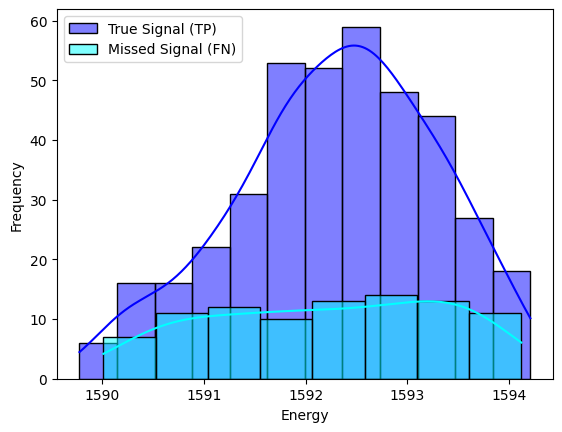

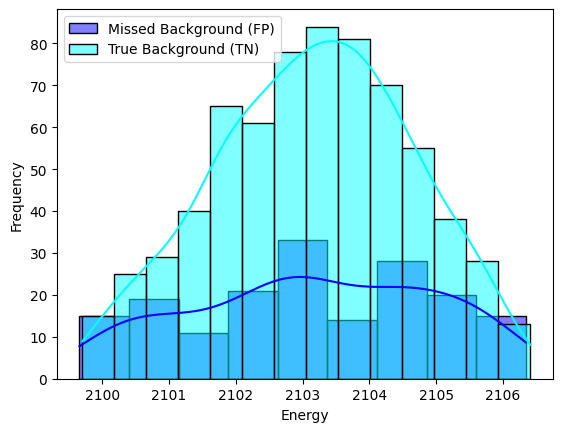

Detector B, TPR: 0.8053830227743272, FPR: 0.21839080459770116


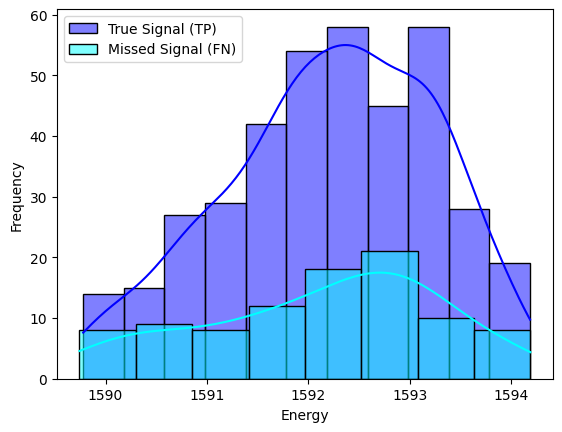

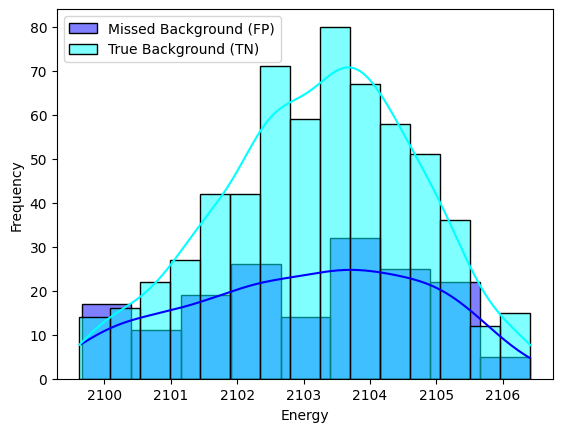

Detector C, TPR: 0.7750556792873051, FPR: 0.20204313280363223


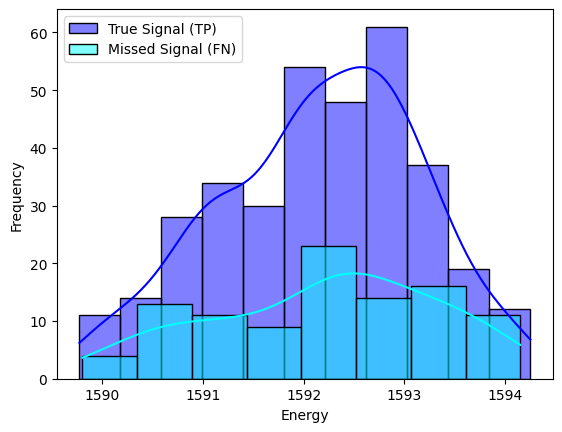

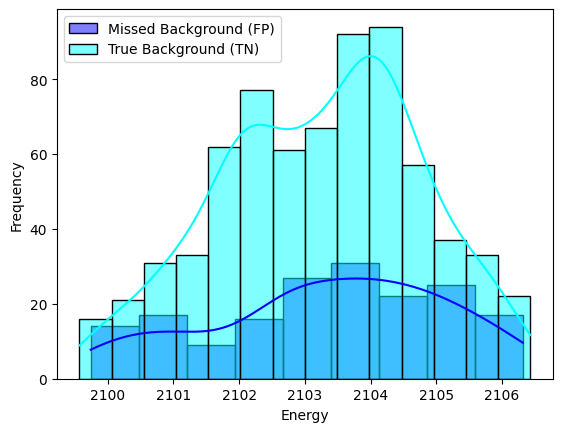

Detector Target, TPR: 0.8421052631578947, FPR: 0.20588235294117646


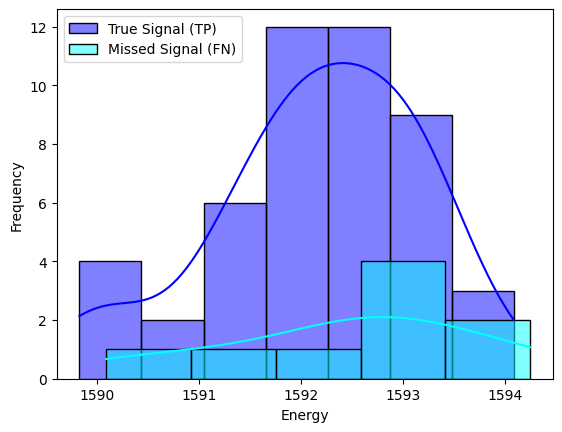

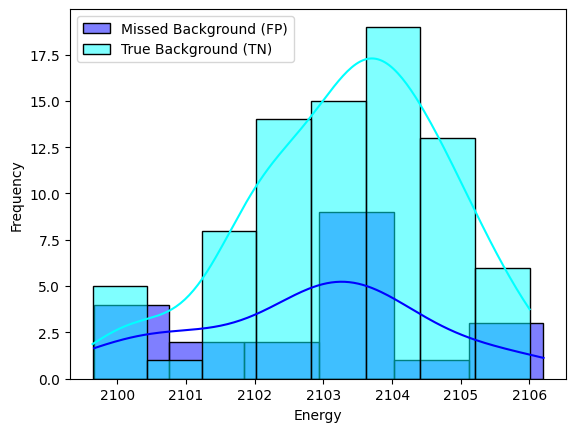

In [33]:
def eval_threshold(signal, background, threshold, name):
    tp = np.sum((signal['class_score'] >= threshold))
    fp = np.sum((background['class_score'] >= threshold))
    fn = np.sum((signal['class_score'] < threshold))
    tn = np.sum((background['class_score'] < threshold))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f"Detector {name}, TPR: {tpr}, FPR: {fpr}")
    sns.histplot(signal[signal['class_score'] >= threshold]['energy'], color='blue', label='True Signal (TP)', kde=True)
    sns.histplot(signal[signal['class_score'] < threshold]['energy'], color='cyan', label='Missed Signal (FN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    sns.histplot(background[background['class_score'] >= threshold]['energy'], color='blue', label='Missed Background (FP)', kde=True)
    sns.histplot(background[background['class_score'] < threshold]['energy'], color='cyan', label='True Background (TN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

eval_threshold(true_A_signal_energy, true_A_background_energy, THRESHOLD, 'A')
eval_threshold(B_signal_energy, B_background_energy, THRESHOLD, 'B')
eval_threshold(C_signal_energy, C_background_energy, THRESHOLD, 'C')
eval_threshold(target_signal_energy, target_background_energy, THRESHOLD, 'Target')
    